# Modèle 3: EfficientNet-B3 avec Transfer Learning

Utilise EfficientNet-B3 pour un compromis optimal entre:
- Performance
- Efficacité computationnelle
- Taille du modèle

Inclut Grad-CAM pour l'explicabilité.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import cv2

# Installer efficientnet si nécessaire
try:
    from efficientnet_pytorch import EfficientNet
except ImportError:
    print("📦 Installation de efficientnet_pytorch...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'efficientnet_pytorch'])
    from efficientnet_pytorch import EfficientNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

🖥️  Device: cpu


## 1. Dataset et DataLoader

In [4]:
from torch.utils.data import Dataset

class SpiceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        
        for class_name in self.class_names:
            class_dir = self.root_dir / class_name
            for img_path in class_dir.glob('*.jpg'):
                self.images.append(img_path)
                self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# EfficientNet-B3 utilise 300x300
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Créer datasets
train_dataset = SpiceDataset('../dataset/splits/train', transform=train_transform)
val_dataset = SpiceDataset('../dataset/splits/val', transform=val_transform)
test_dataset = SpiceDataset('../dataset/splits/test', transform=val_transform)

print(f"📊 Train: {len(train_dataset)} images")
print(f"📊 Val: {len(val_dataset)} images")
print(f"📊 Test: {len(test_dataset)} images")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

📊 Train: 1540 images
📊 Val: 330 images
📊 Test: 330 images


## 2. Modèle EfficientNet-B3

In [5]:
# Charger EfficientNet-B3 pré-entraîné
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=11)
model = model.to(device)

print("\n🏗️  Architecture EfficientNet-B3")

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Total paramètres: {total_params:,}")
print(f"📊 Paramètres entraînables: {trainable_params:,}")

Loaded pretrained weights for efficientnet-b3

🏗️  Architecture EfficientNet-B3

📊 Total paramètres: 10,713,139
📊 Paramètres entraînables: 10,713,139


## 3. Entraînement

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [11]:
# Entraîner le modèle
num_epochs = 30
best_val_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*50}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    scheduler.step()
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'model_efficientnet_best.pth')
        print(f"✅ Meilleur modèle sauvegardé! Val Acc: {val_acc:.2f}%")


Epoch 1/30


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training: 100%|██████████| 97/97 [22:10<00:00, 13.71s/it]


Train Loss: 0.7686 | Train Acc: 77.27%
Val Loss: 4.2219 | Val Acc: 65.76%
Learning Rate: 0.001000
✅ Meilleur modèle sauvegardé! Val Acc: 65.76%

Epoch 2/30


Training: 100%|██████████| 97/97 [20:14<00:00, 12.53s/it]


Train Loss: 0.3879 | Train Acc: 87.92%
Val Loss: 0.5820 | Val Acc: 81.82%
Learning Rate: 0.000997
✅ Meilleur modèle sauvegardé! Val Acc: 81.82%

Epoch 3/30


Training: 100%|██████████| 97/97 [20:34<00:00, 12.72s/it]


Train Loss: 0.2355 | Train Acc: 93.05%
Val Loss: 0.1992 | Val Acc: 95.76%
Learning Rate: 0.000989
✅ Meilleur modèle sauvegardé! Val Acc: 95.76%

Epoch 4/30


Training: 100%|██████████| 97/97 [20:39<00:00, 12.78s/it]


Train Loss: 0.2229 | Train Acc: 94.22%
Val Loss: 12.3620 | Val Acc: 76.67%
Learning Rate: 0.000976

Epoch 5/30


Training: 100%|██████████| 97/97 [20:21<00:00, 12.60s/it]


Train Loss: 0.2063 | Train Acc: 94.09%
Val Loss: 0.6392 | Val Acc: 84.85%
Learning Rate: 0.000957

Epoch 6/30


Training: 100%|██████████| 97/97 [20:37<00:00, 12.76s/it]


Train Loss: 0.1678 | Train Acc: 95.00%
Val Loss: 0.2639 | Val Acc: 93.94%
Learning Rate: 0.000933

Epoch 7/30


Training: 100%|██████████| 97/97 [20:53<00:00, 12.92s/it]


Train Loss: 0.1112 | Train Acc: 96.75%
Val Loss: 0.5155 | Val Acc: 89.09%
Learning Rate: 0.000905

Epoch 8/30


Training: 100%|██████████| 97/97 [21:06<00:00, 13.05s/it]


Train Loss: 0.0967 | Train Acc: 97.27%
Val Loss: 0.9923 | Val Acc: 85.76%
Learning Rate: 0.000872

Epoch 9/30


Training: 100%|██████████| 97/97 [20:56<00:00, 12.95s/it]


Train Loss: 0.1043 | Train Acc: 97.08%
Val Loss: 0.5256 | Val Acc: 88.48%
Learning Rate: 0.000835

Epoch 10/30


Training: 100%|██████████| 97/97 [20:16<00:00, 12.54s/it]


Train Loss: 0.0678 | Train Acc: 97.79%
Val Loss: 0.2326 | Val Acc: 94.24%
Learning Rate: 0.000794

Epoch 11/30


Training: 100%|██████████| 97/97 [20:03<00:00, 12.40s/it]


Train Loss: 0.0895 | Train Acc: 97.27%
Val Loss: 0.0991 | Val Acc: 97.58%
Learning Rate: 0.000750
✅ Meilleur modèle sauvegardé! Val Acc: 97.58%

Epoch 12/30


Training: 100%|██████████| 97/97 [20:37<00:00, 12.75s/it]


Train Loss: 0.0340 | Train Acc: 99.03%
Val Loss: 0.1425 | Val Acc: 95.76%
Learning Rate: 0.000704

Epoch 13/30


Training: 100%|██████████| 97/97 [20:19<00:00, 12.57s/it]


Train Loss: 0.0475 | Train Acc: 98.57%
Val Loss: 0.1435 | Val Acc: 96.67%
Learning Rate: 0.000655

Epoch 14/30


Training: 100%|██████████| 97/97 [20:06<00:00, 12.44s/it]


Train Loss: 0.0568 | Train Acc: 98.12%
Val Loss: 0.1436 | Val Acc: 95.45%
Learning Rate: 0.000604

Epoch 15/30


Training: 100%|██████████| 97/97 [20:27<00:00, 12.66s/it]


Train Loss: 0.0305 | Train Acc: 99.16%
Val Loss: 0.1346 | Val Acc: 96.67%
Learning Rate: 0.000553

Epoch 16/30


Training: 100%|██████████| 97/97 [20:03<00:00, 12.40s/it]


Train Loss: 0.0179 | Train Acc: 99.48%
Val Loss: 0.0735 | Val Acc: 97.88%
Learning Rate: 0.000501
✅ Meilleur modèle sauvegardé! Val Acc: 97.88%

Epoch 17/30


Training: 100%|██████████| 97/97 [20:29<00:00, 12.68s/it]


Train Loss: 0.0242 | Train Acc: 99.35%
Val Loss: 0.0963 | Val Acc: 97.88%
Learning Rate: 0.000448

Epoch 18/30


Training: 100%|██████████| 97/97 [20:40<00:00, 12.79s/it]


Train Loss: 0.0066 | Train Acc: 99.94%
Val Loss: 0.0525 | Val Acc: 98.48%
Learning Rate: 0.000397
✅ Meilleur modèle sauvegardé! Val Acc: 98.48%

Epoch 19/30


Training: 100%|██████████| 97/97 [20:09<00:00, 12.47s/it]


Train Loss: 0.0077 | Train Acc: 99.81%
Val Loss: 0.0628 | Val Acc: 98.48%
Learning Rate: 0.000346

Epoch 20/30


Training: 100%|██████████| 97/97 [20:32<00:00, 12.71s/it]


Train Loss: 0.0034 | Train Acc: 99.87%
Val Loss: 0.0500 | Val Acc: 98.48%
Learning Rate: 0.000297

Epoch 21/30


Training: 100%|██████████| 97/97 [20:20<00:00, 12.59s/it]


Train Loss: 0.0065 | Train Acc: 99.94%
Val Loss: 0.0433 | Val Acc: 98.79%
Learning Rate: 0.000251
✅ Meilleur modèle sauvegardé! Val Acc: 98.79%

Epoch 22/30


Training: 100%|██████████| 97/97 [20:09<00:00, 12.47s/it]


Train Loss: 0.0108 | Train Acc: 99.74%
Val Loss: 0.0975 | Val Acc: 98.18%
Learning Rate: 0.000207

Epoch 23/30


Training: 100%|██████████| 97/97 [20:31<00:00, 12.70s/it]


Train Loss: 0.0086 | Train Acc: 99.81%
Val Loss: 0.0896 | Val Acc: 97.88%
Learning Rate: 0.000166

Epoch 24/30


Training: 100%|██████████| 97/97 [20:14<00:00, 12.52s/it]


Train Loss: 0.0023 | Train Acc: 99.94%
Val Loss: 0.0809 | Val Acc: 98.18%
Learning Rate: 0.000129

Epoch 25/30


Training: 100%|██████████| 97/97 [20:42<00:00, 12.81s/it]


Train Loss: 0.0036 | Train Acc: 100.00%
Val Loss: 0.0816 | Val Acc: 98.18%
Learning Rate: 0.000096

Epoch 26/30


Training: 100%|██████████| 97/97 [20:22<00:00, 12.61s/it]


Train Loss: 0.0029 | Train Acc: 99.94%
Val Loss: 0.0790 | Val Acc: 98.18%
Learning Rate: 0.000068

Epoch 27/30


Training: 100%|██████████| 97/97 [20:24<00:00, 12.62s/it]


Train Loss: 0.0023 | Train Acc: 100.00%
Val Loss: 0.0752 | Val Acc: 98.18%
Learning Rate: 0.000044

Epoch 28/30


Training: 100%|██████████| 97/97 [20:12<00:00, 12.50s/it]


Train Loss: 0.0051 | Train Acc: 99.81%
Val Loss: 0.0608 | Val Acc: 98.48%
Learning Rate: 0.000025

Epoch 29/30


Training: 100%|██████████| 97/97 [20:15<00:00, 12.53s/it]


Train Loss: 0.0112 | Train Acc: 99.94%
Val Loss: 0.0613 | Val Acc: 98.18%
Learning Rate: 0.000012

Epoch 30/30


Training: 100%|██████████| 97/97 [20:42<00:00, 12.81s/it]


Train Loss: 0.0014 | Train Acc: 100.00%
Val Loss: 0.0673 | Val Acc: 98.18%
Learning Rate: 0.000004


## 4. Visualisation des Résultats

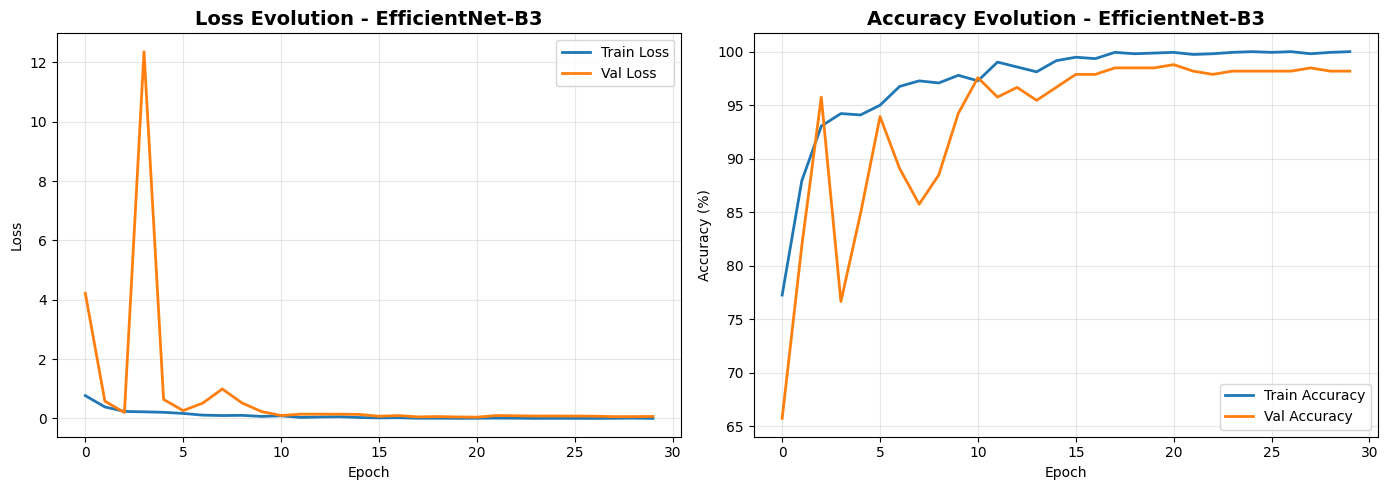

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Loss Evolution - EfficientNet-B3', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy Evolution - EfficientNet-B3', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Évaluation sur le Test Set


📊 Classification Report - EfficientNet-B3:
              precision    recall  f1-score   support

        anis       1.00      0.97      0.98        30
    cannelle       1.00      0.97      0.98        30
       carvi       1.00      1.00      1.00        30
clou_girofle       0.97      1.00      0.98        30
      cubebe       0.97      1.00      0.98        30
       cumin       0.97      1.00      0.98        30
     curcuma       0.97      1.00      0.98        30
   gingembre       1.00      1.00      1.00        30
     paprika       1.00      1.00      1.00        30
 poivre noir       1.00      0.93      0.97        30
      safran       1.00      1.00      1.00        30

    accuracy                           0.99       330
   macro avg       0.99      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330



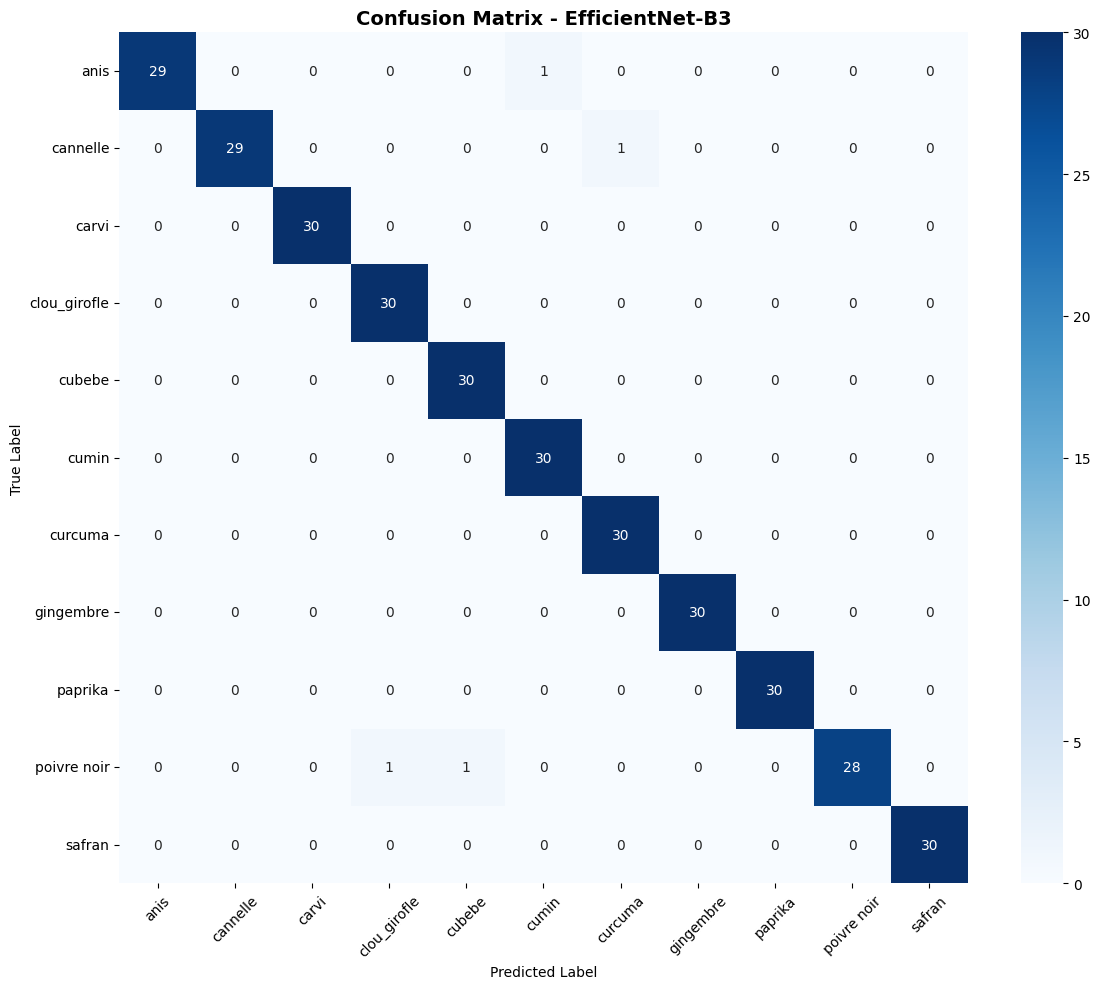

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Charger le meilleur modèle
checkpoint = torch.load('../models/model_efficientnet_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Évaluer
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\n📊 Classification Report - EfficientNet-B3:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.class_names,
            yticklabels=train_dataset.class_names)
plt.title('Confusion Matrix - EfficientNet-B3', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Explainability: Grad-CAM

In [7]:
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Hook sur la dernière couche conv
        # Pour EfficientNet: _conv_head
        target_layer = model._conv_head
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate(self, image, class_idx):
        self.model.eval()
        image = image.unsqueeze(0).to(device)
        image.requires_grad = True
        
        # Forward
        output = self.model(image)
        
        # Backward
        self.model.zero_grad()
        output[0, class_idx].backward()
        
        # Compute CAM
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = np.maximum(cam, 0)
        cam = cam / cam.max() if cam.max() != 0 else cam
        cam = cv2.resize(cam, (300, 300))
        
        return cam

# Créer Grad-CAM
gradcam = GradCAM(model)

c:\Users\zaineb\.conda\envs\spices_env\lib\site-packages\torch\nn\modules\module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


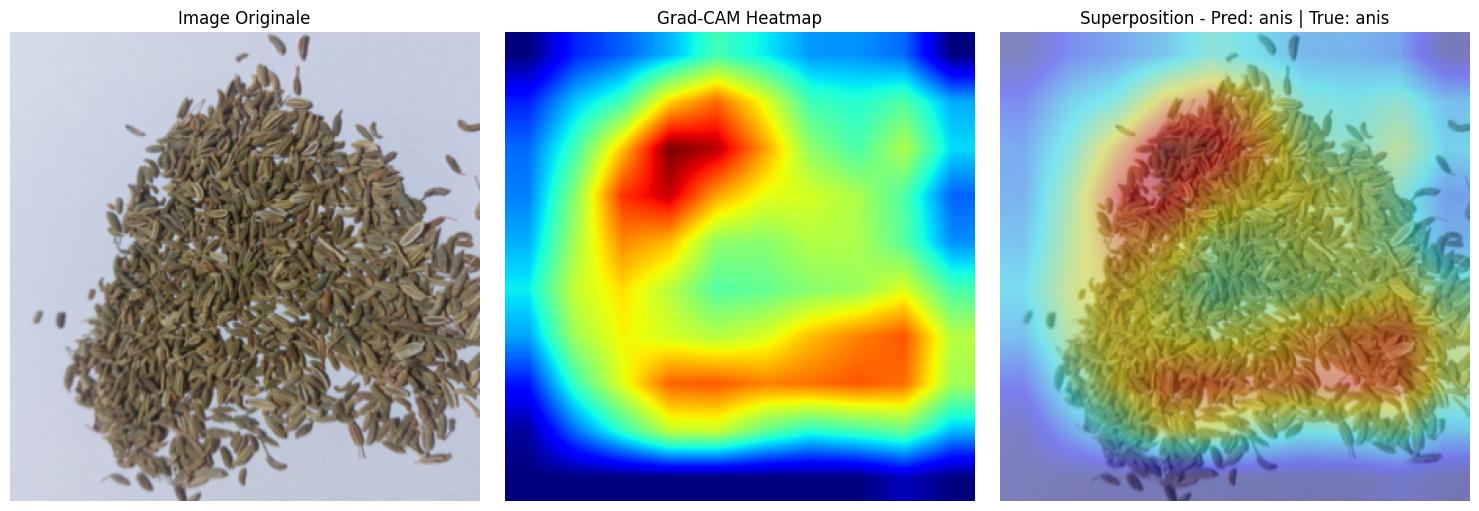

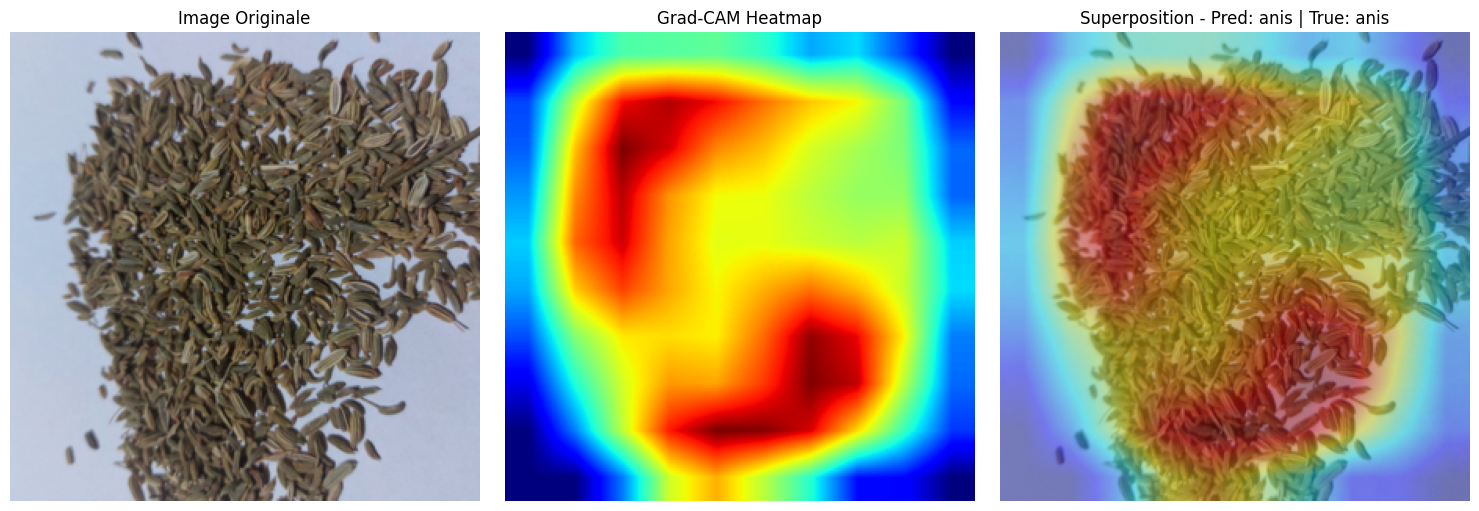

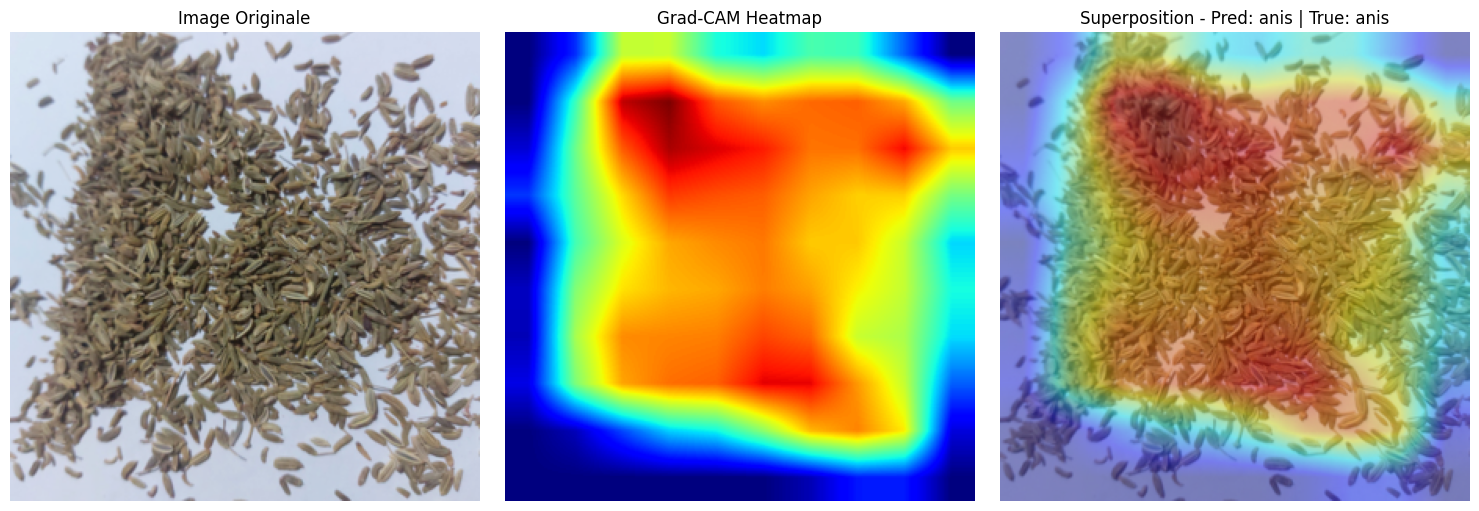

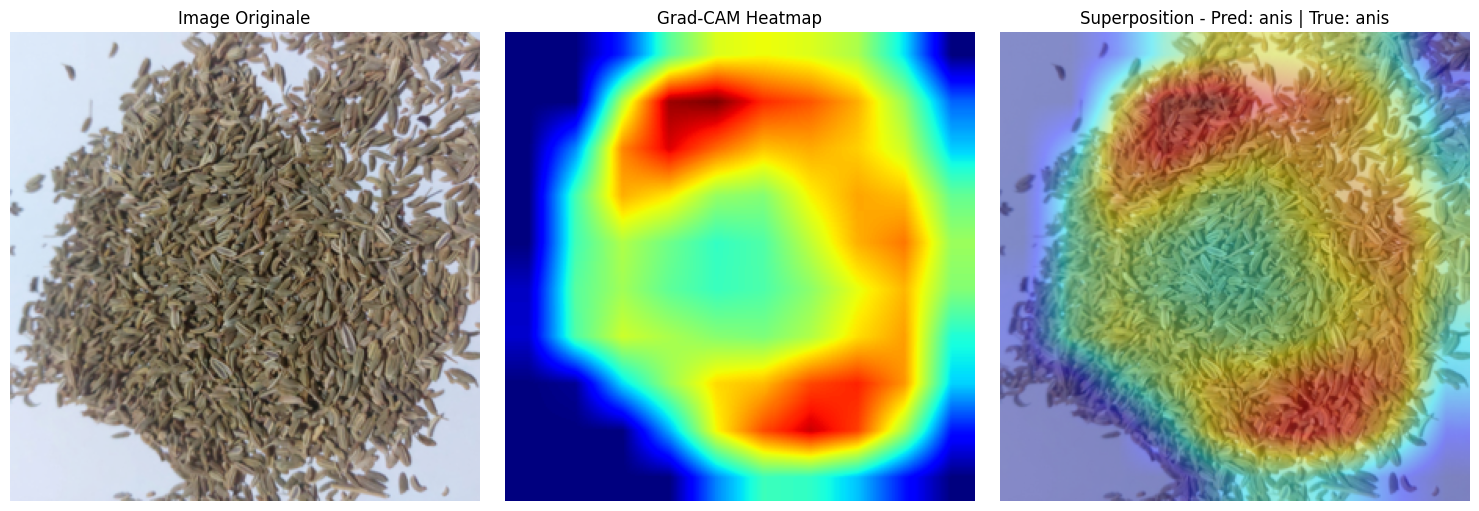

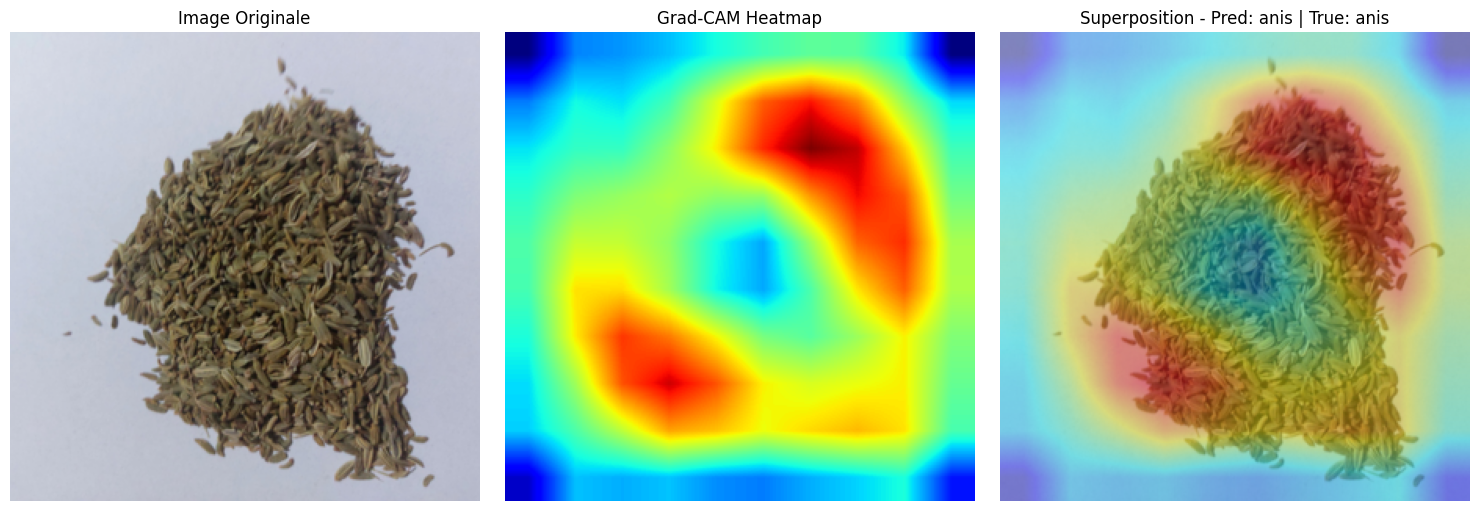

In [8]:
def show_gradcam(image, cam, title):
    # Dénormaliser l'image
    img = image.cpu().numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    # Créer heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Superposer
    overlay = 0.6 * img + 0.4 * heatmap
    overlay = np.clip(overlay, 0, 1)
    
    # Afficher
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Image Originale')
    axes[0].axis('off')
    
    axes[1].imshow(cam, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    
    axes[2].imshow(overlay)
    axes[2].set_title(f'Superposition - {title}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualiser sur quelques exemples
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(min(5, len(images))):
    image = images[i]
    label = labels[i].item()
    
    # Prédiction
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = output.argmax(1).item()
    
    # Générer Grad-CAM
    cam = gradcam.generate(image, pred)
    
    # Afficher
    title = f"Pred: {train_dataset.class_names[pred]} | True: {train_dataset.class_names[label]}"
    show_gradcam(image, cam, title)

## 6.1 Grad-CAM Interactif: Explorez d'autres classes

🌶️  Épices disponibles:
   0: anis
   1: cannelle
   2: carvi
   3: clou_girofle
   4: cubebe
   5: cumin
   6: curcuma
   7: gingembre
   8: paprika
   9: poivre noir
   10: safran

📝 Exemple d'utilisation:
   spice_idx = 0  # Anis
   image_idx = 0  # Première image de cette épice
   visualize_gradcam_for_spice(spice_idx, image_idx)

🌶️  Visualisation Grad-CAM: CANNELLE

📸 Image: cannelle_0078.jpg

🎯 Prédictions du modèle:
   ✅ #1: cannelle        (100.00%)
   ❌ #2: clou_girofle    (0.00%)
   ❌ #3: curcuma         (0.00%)

🔍 Génération Grad-CAM...


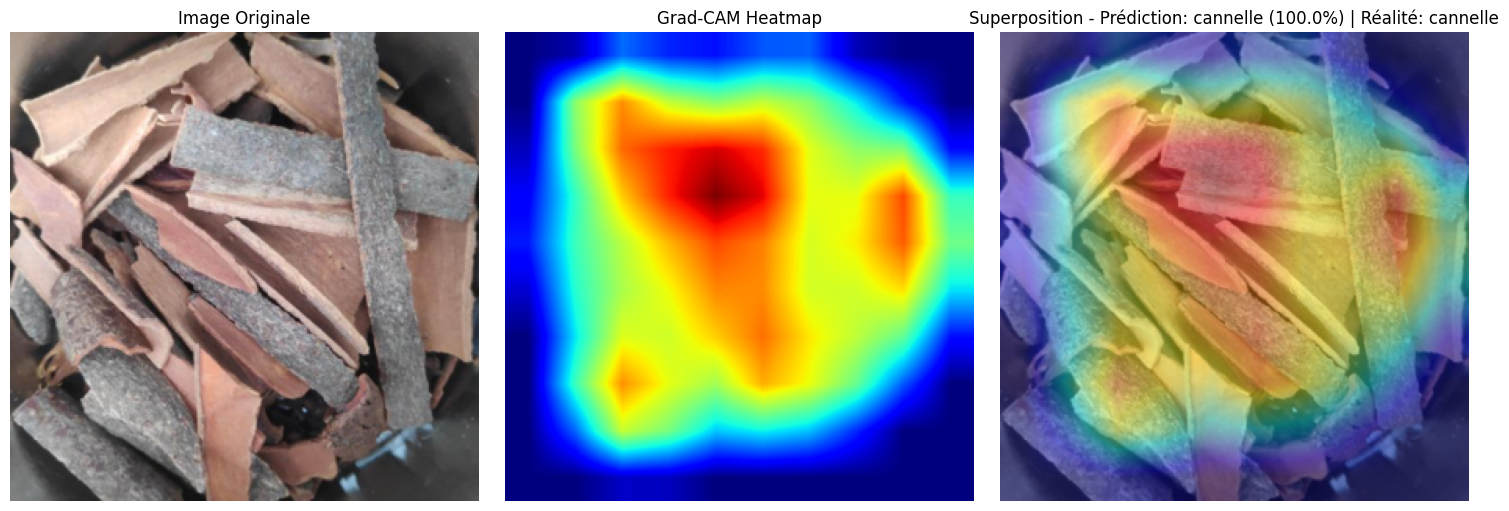


✅ Fonction visualize_gradcam_for_spice() disponible!
💡 Décommentez les exemples ci-dessus ou appelez la fonction avec vos paramètres


In [25]:
# ====================================
# GRAD-CAM INTERACTIF: Tester d'autres épices
# ====================================

# Afficher les noms de toutes les classes disponibles
print("🌶️  Épices disponibles:")
for idx, spice in enumerate(train_dataset.class_names):
    print(f"   {idx}: {spice}")

print("\n📝 Exemple d'utilisation:")
print("   spice_idx = 0  # Anis")
print("   image_idx = 0  # Première image de cette épice")
print("   visualize_gradcam_for_spice(spice_idx, image_idx)")

def visualize_gradcam_for_spice(spice_idx, image_idx=0):
    """
    Visualiser Grad-CAM pour une épice et une image spécifiques
    
    Args:
        spice_idx: Indice de l'épice (0-10)
        image_idx: Indice de l'image dans le test set pour cette épice
    """
    spice_name = train_dataset.class_names[spice_idx]
    print(f"\n{'='*60}")
    print(f"🌶️  Visualisation Grad-CAM: {spice_name.upper()}")
    print(f"{'='*60}\n")
    
    # Charger l'image directement depuis le dossier
    spice_folder = Path(f'../dataset/splits/test/{spice_name}')
    spice_images = sorted(list(spice_folder.glob('*.jpg')))
    
    if image_idx >= len(spice_images):
        print(f"⚠️  Il n'y a que {len(spice_images)} images pour {spice_name}")
        image_idx = 0
    
    img_path = spice_images[image_idx]
    print(f"📸 Image: {img_path.name}")
    
    # Charger et traiter l'image
    image = Image.open(img_path).convert('RGB')
    image_tensor = val_transform(image)
    
    # Prédiction
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(device))
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        pred_idx = output.argmax(1).item()
        pred_prob = probabilities[pred_idx].item() * 100
        
        # Top 3 prédictions
        top3_probs, top3_indices = torch.topk(probabilities, 3)
    
    # Afficher les prédictions
    print(f"\n🎯 Prédictions du modèle:")
    for i, (prob, idx) in enumerate(zip(top3_probs, top3_indices)):
        spice = train_dataset.class_names[idx.item()]
        confidence = prob.item() * 100
        marker = "✅" if idx.item() == spice_idx else "❌"
        print(f"   {marker} #{i+1}: {spice:15} ({confidence:.2f}%)")
    
    # Générer Grad-CAM pour la prédiction
    print(f"\n🔍 Génération Grad-CAM...")
    cam = gradcam.generate(image_tensor, pred_idx)
    
    # Afficher
    title = f"Prédiction: {train_dataset.class_names[pred_idx]} ({pred_prob:.1f}%) | Réalité: {spice_name}"
    show_gradcam(image_tensor, cam, title)
    
    return image_tensor, cam, pred_idx

# ====================================
# EXEMPLE: Tester différentes épices
# ====================================

# Exemple 1: Anis (classe 0)
#visualize_gradcam_for_spice(spice_idx=0, image_idx=0)

# Exemple 2: Cumin (classe 5)
#visualize_gradcam_for_spice(spice_idx=5, image_idx=0)

# Exemple 3: Safran (classe 10)
#visualize_gradcam_for_spice(spice_idx=10, image_idx=0)
# Autres
#visualize_gradcam_for_spice(spice_idx=3, image_idx=8)
visualize_gradcam_for_spice(spice_idx=1, image_idx=11)
print("\n✅ Fonction visualize_gradcam_for_spice() disponible!")
print("💡 Décommentez les exemples ci-dessus ou appelez la fonction avec vos paramètres")
